![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым ~~королём~~ функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__  # ОУУУУ ЩИИИИТ, ВТОРАЯ ВЕРСИЯ!!! АААААААААААА

'2.0.0'

# 0. Tensoflow teaser

Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

In [3]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%timeit
N = 10**8
np_sum_squares(N)

1.52 s ± 53.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их, работает быстрее.

In [5]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [6]:
%%timeit
N = 10**8
tf_sum_squares(N)

934 ms ± 47.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё сильнее ускорит код. 

In [7]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [8]:
%%timeit
N = 10**8
tf_sum_squares(N)

237 µs ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [9]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: id=105, shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [10]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

<tf.Tensor: id=108, shape=(3, 4, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]], dtype=float32)>

In [11]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: id=114, shape=(2, 2), dtype=float32, numpy=
array([[-1.546859  ,  0.09800889],
       [-1.3550535 , -0.2534152 ]], dtype=float32)>

In [12]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: id=117, shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [13]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [14]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: id=118, shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [15]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: id=119, shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]], dtype=int32)>

In [16]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [17]:
x.dtype

tf.float32

In [18]:
x.shape

TensorShape([3, 4])

In [19]:
x[0]

<tf.Tensor: id=124, shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [20]:
x[:,1]

<tf.Tensor: id=128, shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [21]:
x + 10

<tf.Tensor: id=130, shape=(3, 4), dtype=float32, numpy=
array([[11., 12., 13., 14.],
       [15., 16., 17., 18.],
       [19., 20., 21., 22.]], dtype=float32)>

In [22]:
x[x > 3]

<tf.Tensor: id=159, shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [23]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [24]:
x + y

<tf.Tensor: id=161, shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [25]:
x**y

<tf.Tensor: id=162, shape=(3, 4), dtype=float32, numpy=
array([[1.00000e+00, 2.04800e+03, 5.90490e+04, 2.62144e+05],
       [3.90625e+05, 2.79936e+05, 1.17649e+05, 3.27680e+04],
       [6.56100e+03, 1.00000e+03, 1.21000e+02, 1.20000e+01]],
      dtype=float32)>

In [26]:
tf.math.exp(x)

<tf.Tensor: id=163, shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598152e+01],
       [1.4841316e+02, 4.0342880e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030840e+03, 2.2026465e+04, 5.9874141e+04, 1.6275480e+05]],
      dtype=float32)>

In [27]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [28]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: id=164, shape=(), dtype=string, numpy=b'hello world'>

### Задание 1:

Попробуйте реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [5]:
x = tf.linspace(-1.,1.,10)

def sigmoida(x):
    return 1/(1 + tf.math.exp(-x))

sigmoida(x)

<tf.Tensor: id=18, shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.4722508 ,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

### Задание 2:

Попробуйте реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \sum_{i=1}^n (\hat y - y)^2
$$

In [12]:
y_true = tf.constant([1,2,3,4,5])
y_predicted = tf.constant([5,4,3,2,1])

# Ваш код
def mse(y, yp):
    return tf.reduce_sum(tf.math.pow((yp - y), 2), axis=0)

mse(y_true, y_predicted)

<tf.Tensor: id=53, shape=(), dtype=int32, numpy=40>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [13]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = y**2

In [14]:
t.gradient(z, x)

<tf.Tensor: id=68, shape=(2,), dtype=float32, numpy=array([2.6, 2.6], dtype=float32)>

In [15]:
t.gradient(z, y)

<tf.Tensor: id=74, shape=(), dtype=float32, numpy=2.6>

Нарисуем функцию и её производную на картинке :) 

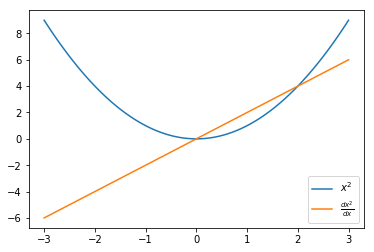

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();

### Задание 3:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [27]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

# ваш код
def f(w):
    return tf.reduce_prod(tf.math.log(tf.math.log(w +7)))

with tf.GradientTape(persistent=True) as t:
    t.watch(w)
    y = f(w)

In [28]:
t.gradient(y, w)

<tf.Tensor: id=425, shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [29]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [30]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [31]:
x*w

<tf.Tensor: id=437, shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

### Задание 4:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [36]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])

# ваш код
def f(w):
    return tf.reduce_prod(tf.math.log(tf.math.log(w +7)))

with tf.GradientTape(persistent=True) as t:
    y = f(w)

In [37]:
t.gradient(y, w)

<tf.Tensor: id=575, shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [53]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [54]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([-0.48532274], dtype=float32), array([-1.4572259], dtype=float32))

In [55]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [56]:
linear_regression(celsius).numpy()

array([ 57.803715  ,  14.086936  ,  -0.48532274, -12.14313   ,
       -22.343712  , -32.544292  , -55.859905  ], dtype=float32)

In [57]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

7977.159

In [58]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))
    pass

In [49]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([1.3509521], dtype=float32)>

In [50]:
model_train(celsius, fahrenheit)

In [51]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([1.4390492], dtype=float32)>

In [52]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 892.001831, a: 1.494152, b: 2.010782
step: 100, loss: 606.569336, a: 6.821049, b: 2.010041
step: 200, loss: 412.985596, a: 11.216064, b: 1.972950
step: 300, loss: 281.189453, a: 14.842480, b: 1.942346
step: 400, loss: 191.459930, a: 17.834702, b: 1.917094
step: 500, loss: 130.369949, a: 20.303648, b: 1.896257
step: 600, loss: 88.778687, a: 22.340820, b: 1.879065
step: 700, loss: 60.462498, a: 24.021729, b: 1.864879
step: 800, loss: 41.184338, a: 25.408669, b: 1.853175
step: 900, loss: 28.059355, a: 26.553061, b: 1.843517
step: 1000, loss: 19.123487, a: 27.497330, b: 1.835548
step: 1100, loss: 13.039793, a: 28.276461, b: 1.828973
step: 1200, loss: 8.897882, a: 28.919336, b: 1.823547
step: 1300, loss: 6.077971, a: 29.449787, b: 1.819070
step: 1400, loss: 4.158154, a: 29.887463, b: 1.815377
step: 1500, loss: 2.851107, a: 30.248598, b: 1.812329
step: 1600, loss: 1.961223, a: 30.546579, b: 1.809814
step: 1700, loss: 1.355368, a: 30.792452, b: 1.807739
step: 1800, loss: 0.9428

Можно сделать то же самое, но с визуализацией. 

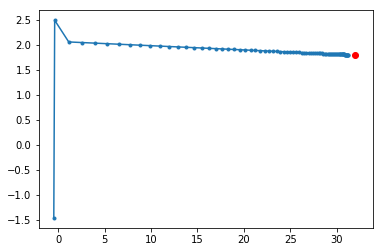

In [59]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

### Задание 5:

Реализуйте для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

процедуру градиентного спуска. Каким получилось минимальное значение? 

In [70]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])

optimizer = tf.optimizers.Adam(learning_rate=0.1)

def f(w):
    return tf.reduce_prod(tf.math.log(tf.math.log(w +7)))

def model_train(w):
    with tf.GradientTape() as g:
        y = f(w)
        
    gradients = g.gradient(y, [w])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [w]))
    pass

In [71]:
for i in range(4):
    model_train(w)
    print(w.numpy(), '\n')

[[4.900016   9.900029  ]
 [0.90000707 1.900009  ]] 

[[4.8000407  9.800079  ]
 [0.79999614 1.80001   ]] 

[[4.7000866 9.700174 ]
 [0.6999564 1.6999998]] 

[[4.600167  9.600339 ]
 [0.5998785 1.5999771]] 



------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [72]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [73]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [74]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

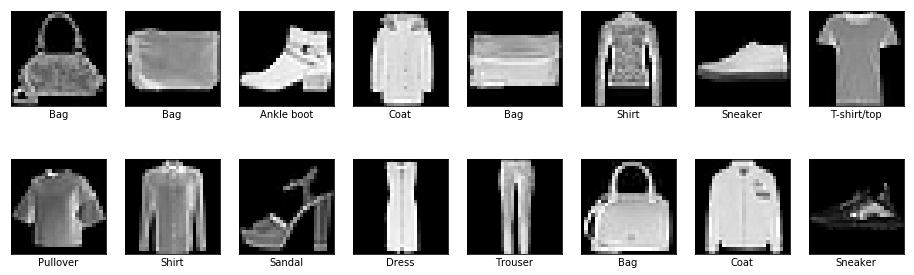

In [75]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [76]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Картинка - матрица. 

In [55]:
X_train[0].shape

(28, 28)

Давайте отнормируем выборку. 

In [77]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [78]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [79]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [80]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [81]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Задание 6

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [86]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

# ваши переменные
W = tf.Variable(initial_value= tf.random.normal([num_features, num_classes]))
b = tf.Variable(initial_value= tf.random.normal([num_classes]))


def logistic_regression(X):
    h = X@W + b
    return tf.nn.softmax(h)

In [87]:
p_pred = logistic_regression(X_train[:3])
p_pred

<tf.Tensor: id=166810, shape=(3, 10), dtype=float32, numpy=
array([[1.2963397e-02, 6.8413577e-08, 6.9932359e-01, 9.9403330e-10,
        1.0169447e-01, 1.6502706e-16, 1.8601851e-01, 4.3777543e-14,
        7.9675654e-13, 8.0923867e-17],
       [1.1733861e-10, 3.7717144e-23, 6.1130677e-11, 1.9496089e-16,
        1.4723667e-08, 9.4023643e-11, 1.0000000e+00, 4.9546803e-18,
        1.0467828e-18, 1.1770294e-16],
       [2.7254168e-06, 1.7771624e-11, 5.0419883e-04, 2.1056723e-05,
        5.1116315e-04, 1.0986821e-02, 9.8797262e-01, 3.4669234e-10,
        1.5294967e-10, 1.4048214e-06]], dtype=float32)>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [94]:
tf.math.log(p_pred[:3])*y_train[:3]

<tf.Tensor: id=166863, shape=(3, 10), dtype=float32, numpy=
array([[ -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      , -37.053024],
       [-22.865957,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,   0.      ,  -0.      ,  -0.      ,  -0.      ],
       [-12.812889,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ]],
      dtype=float32)>

In [93]:
-1*tf.reduce_sum(tf.math.log(p_pred[:3])*y_train[:3], axis=1)

<tf.Tensor: id=166856, shape=(3,), dtype=float32, numpy=array([37.053024, 22.865957, 12.812889], dtype=float32)>

In [95]:
tf.reduce_mean(-1*tf.reduce_sum(tf.math.log(p_pred[:3])*y_train[:3], axis=1))

<tf.Tensor: id=166876, shape=(), dtype=float32, numpy=24.243958>

In [126]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

In [127]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

<tf.Tensor: id=1069466, shape=(), dtype=float32, numpy=1.0731955>

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [128]:
def accuracy(p_pred, y_true):
    acc = tf.equal(tf.argmax(p_pred,axis=1) ,tf.argmax(y_true,axis=1))
    acc = tf.cast(acc, tf.float32)
    return tf.reduce_mean(acc)

In [129]:
accuracy(p_pred, y_train)

<tf.Tensor: id=1069475, shape=(), dtype=float32, numpy=0.7521667>

Задаём оптимизатор

In [130]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [131]:
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [W, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))
    pass

In [132]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-7.4582905e-01,  1.7771503e-02,  7.1350884e-01, ...,
         4.1986200e-01, -1.6827706e-01,  8.6010444e-01],
       [ 9.4220228e-03,  5.6527048e-01, -9.8610759e-01, ...,
        -1.0506601e+00, -1.8583906e-03,  8.1163532e-01],
       [ 8.1512386e-01, -1.0976586e+00, -4.8436916e-01, ...,
        -3.3295277e-01,  2.3352478e-01, -9.1162640e-01],
       ...,
       [-2.3041115e+00, -6.5209126e-01,  5.3739846e-01, ...,
        -7.4331003e-01,  6.8216270e-01,  1.1816096e+00],
       [ 3.1662762e-01,  6.5020001e-01,  7.4202460e-01, ...,
        -5.0433391e-01,  1.3801111e-01,  3.3990586e-01],
       [ 3.7418705e-01, -7.3014659e-01, -4.4529608e-01, ...,
        -6.9286740e-01, -3.0952725e-01,  7.6571661e-01]], dtype=float32)>

In [133]:
# Работает ли?
model_train(X_train, y_train)

In [134]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-7.4583524e-01,  1.7771497e-02,  7.1348614e-01, ...,
         4.1986200e-01, -1.6829863e-01,  8.6010444e-01],
       [ 9.4363568e-03,  5.6527066e-01, -9.8611867e-01, ...,
        -1.0506601e+00, -1.8660331e-03,  8.1163907e-01],
       [ 8.1514531e-01, -1.0976939e+00, -4.8434538e-01, ...,
        -3.3295357e-01,  2.3346311e-01, -9.1162282e-01],
       ...,
       [-2.3042090e+00, -6.5201521e-01,  5.3749460e-01, ...,
        -7.4335796e-01,  6.8206429e-01,  1.1815149e+00],
       [ 3.1653282e-01,  6.5027922e-01,  7.4212092e-01, ...,
        -5.0432277e-01,  1.3791388e-01,  3.3984929e-01],
       [ 3.7419879e-01, -7.3016876e-01, -4.4521207e-01, ...,
        -6.9287407e-01, -3.0960977e-01,  7.6577449e-01]], dtype=float32)>

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [135]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [136]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

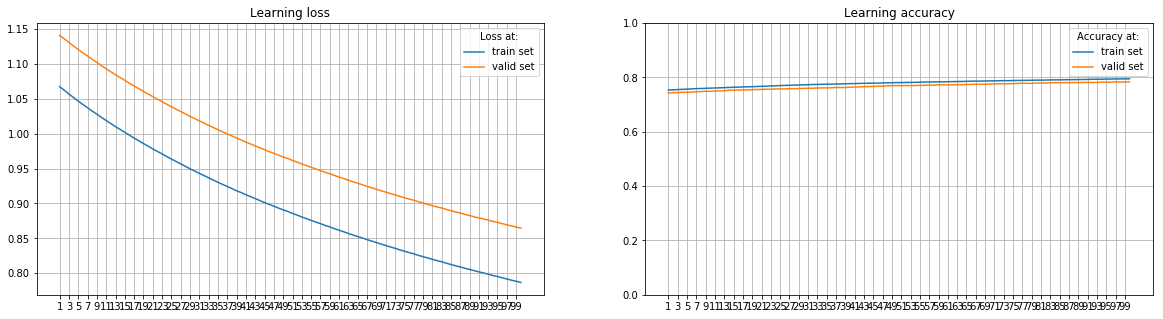

In [137]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test)

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Задание 7

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. Функцию, где будет реализована модель назовите `our_nn`.

In [82]:
# Ваш код

Обучаем модель!

In [ ]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

# N+1. Как Tensorflow работал раньше 

Больше такой код не надо писать никогда и нигде. Если видите его в туториалах в интернете, сразу закрывайте их. Эти туториалы устарели. Можете попробовать подуть на них (сдуть слой пыли), а дальше попробовать самостоятельно переписать старый код на новый. Это неплохое упражнение :) 

In [1]:
import tensorflow.compat.v1 as tf  # подгружаем первую версию библиотеки 
tf.disable_v2_behavior()           # отключаем функционал второй 
                                   # теперь код, написанный на версии tf 1.x должен работать 
tf.__version__

W1003 17:53:59.017053 140735755330496 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


'2.0.0'

Раньше сначала надо было задать структуру вычислений с помощью тензоров. 

In [2]:
# что происходило в первой версии 
a = tf.constant([1, 2])
b = tf.constant([3, 4])

print(a + b)

Tensor("add:0", shape=(2,), dtype=int32)


Результат на лету было увидеть нельзя. 

In [4]:
c = a + b
c

<tf.Tensor 'add_2:0' shape=(2,) dtype=int32>

Если хотелось результата, надо было запускать вычислительную сессию, которая прогоняла все данные через граф.

In [6]:
# открываем вычислительную сессию 
with tf.Session() as sess:
    print(sess.run(c))

[4 6]


In [7]:
# либо можно было открыть глобальную сессию 
sess = tf.InteractiveSession()
c.eval()

array([4, 6], dtype=int32)

Процедура обучения модели выглядела раньше иначе. Кроме переменных в обучении участие принимал ещё один объект, `placeholder`. 

* __placeholder__ — место в графе, которое может принимать входные параметры в граф извне. В эти места мы будем вставлять наши данные

In [ ]:
epochs = 10

# плейсхолдеры для данных 
# "Я обещаю вставить сюда x и y позже"
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# параметры модели 
a = tf.Variable(tf.zeros([1]), name='bias')
b = tf.Variable(tf.zeros([1]), name='k')

# модель 
y_hat = b*x + a

# функция потерь и метод оптимизации
loss = tf.sqrt(tf.reduce_sum((y - y_hat)**2))
opt = tf.train.AdamOptimizer(learning_rate = 0.1)

# из-за того, что не было динамических вычислений, 
# было проще с градиентами
step = opt.minimize(loss)

# Но зато было сложнее с процедурой обучения, надо было запускать ... сессии
# открываем вычислительную сессию 
with tf.Session() as sess:
    
    # инициализировали все переменные 
    tf.global_variables_initializer().run() 
    
    for i in range(epochs):
        
        # Дорогая сессия, вычисли мне результат функции потерь, пожалуйста! Вот тебе конкретные x и y! 
        cur_loss = sess.run(loss, feed_dict={x:celsius, y:fahrenheit})
        print('Текущие потери:', cur_loss)
        
        # шаг оптимизации 
        sess.run(step, feed_dict={x:celsius, y:fahrenheit})
        
    print('\nКоэффициенты:', a.eval()[0], b.eval()[0])
    print('Прогнозы:', sess.run(y_hat, feed_dict={x:[-40,0,38]}))

## Почиташки

* [Эффективный tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2)
* [Простые примеры кода на tensorflow 2.0](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/tensorflow_v2)
* [Очень-очень милая презентация про fashion mnist](https://github.com/fbchow/fashion-mnist-tensorflow/blob/master/ml-fashion-mnist-presentation.pdf)


__Немного старья:__

* [Введение в старую версию Tensorflow на Хабре](https://habrahabr.ru/company/ods/blog/324898/)
* [Введение в старый Tensorflow от ШАД,](https://nbviewer.jupyter.org/github/yandexdataschool/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb) моя тетрадка частично основана на этой тетрадке, хоть сходство на первый взгляд и не заметно. 
* [Неплохая подборка разных тетрадок](https://github.com/Hvass-Labs/TensorFlow-Tutorials) на старом tensorflow